In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Flatten,Attention, Concatenate, Input ,Reshape ,MultiHeadAttention
from tensorflow.keras.optimizers import Adam,RMSprop
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error,precision_score
import numpy as np
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K



In [2]:
file_path = r"/Users/I578087/Desktop/WaterLevel-main/data_2/dataset.csv"
data = pd.read_csv(file_path)

In [3]:
data.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9
0,0.184,106401.5980,103157.1785,1293.4311,592,1150,0.7705,0.2313,0.018043
1,0.184,106399.9771,103155.4379,1293.4311,592,1150,0.7705,0.2313,0.018043
2,0.184,106399.9771,103155.4379,1293.4311,592,1150,0.7705,0.2313,0.000000
3,0.184,106400.7710,103156.2771,1293.4311,592,1150,0.7705,0.2313,0.008414
4,0.184,106402.8029,103158.1105,1293.4311,592,1150,0.7705,0.2313,0.008564


In [4]:
data.drop(['Feature9'],axis=1,inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Feature1  300 non-null    float64
 1   Feature2  300 non-null    float64
 2   Feature3  300 non-null    float64
 3   Feature4  300 non-null    float64
 4   Feature5  300 non-null    int64  
 5   Feature6  300 non-null    int64  
 6   Feature7  300 non-null    float64
 7   Feature8  300 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 18.9 KB


In [5]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Standardize the data
data = scaler.fit_transform(data)

In [6]:
# Create sequences for training (8 rows per year)
def create_sequences(data, seq_length=8, pred_length=20):
    X, y = [], []
    # Ensure the data is in numpy array format
    data = np.array(data)
    
    for i in range(len(data) - seq_length - pred_length + 1):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+pred_length])  # Predict the next pred_length steps
        
    return np.array(X), np.array(y)

# Generate sequences
X, y = create_sequences(data, seq_length=8, pred_length=20)

# Print shapes
print(X.shape)
print(y.shape)

(273, 8, 8)
(273, 20, 8)


In [7]:
X, y = create_sequences(data)

In [8]:
# Split the dataset into training and testing sets (use last 20 rows for testing)
X_train = X[:-20]
y_train = y[:-20]
X_test = X[-20:]
y_test = y[-20:]

In [9]:
print(X_train.shape)
print(y_train.shape)


(253, 8, 8)
(253, 20, 8)


In [60]:
# Custom RMSE metric
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# Custom MAPE metric
def mape(y_true, y_pred):
    return K.mean(K.abs((y_true - y_pred) / K.clip(K.abs(y_true), K.epsilon(), None))) * 100

# Custom accuracy metric
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))

# Custom precision metric
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [52]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Conv1D, Flatten
from tensorflow.keras.models import Model


def create_custom_rnn(input_shape, output_steps, num_features):
    inputs = Input(shape=input_shape)
    
    # Attention Layer
    attention = MultiHeadAttention(num_heads=4, key_dim=8)(inputs, inputs)
    
    # Temporal Convolutional Layer
    conv = Conv1D(filters=32, kernel_size=4, dilation_rate=2, activation='relu')(attention)
    
    # LSTM Layer
    lstm = LSTM(64, return_sequences=True)(conv)
    
    # GRU Layer
    gru = GRU(64)(lstm)
    
    # Concatenate LSTM and GRU outputs
    concat = Concatenate()([lstm[:, -1, :], gru])
    
    # Dense Layers for Output
    dense = Dense(128, activation='relu')(concat)
    outputs = Dense(output_steps * num_features)(dense)
    outputs = tf.keras.layers.Reshape((output_steps, num_features))(outputs)
    
    model = Model(inputs, outputs)
    
    from tensorflow.keras.optimizers import Adam,Adamax,RMSprop,Nadam,Adagrad,SGD,Adadelta
    optimizer = Adamax(learning_rate=0.02)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error', rmse, mape, accuracy, precision])
    return model



In [53]:
# Ensure the input is reshaped for the RNN
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))  # Reshape to (n_samples, time_steps, features)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))      # Same as above

# Reshape y_train and y_test to include the feature dimension
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2]))  # Reshape to (n_samples, steps, features)
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2]))

# Define input and output shapes
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, features)
output_steps = y_train.shape[1]  # Number of steps to predict
num_features = y_train.shape[2]  # Number of features to predict


# Create and compile the model
model = create_custom_rnn(input_shape, output_steps, num_features)
model.summary()



# Train the model
history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_test, y_test), 
    epochs=150, 
    batch_size=20, 
    verbose=1
)



Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 8, 8)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 8, 8)      │      1,128 │ input_layer_10[0… │
│ (MultiHeadAttentio… │                   │            │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 2, 32)     │      1,056 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 2, 64)     │     24,832 │ conv1d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_7          │ (None, 64)        │          0 │ lstm_9[0][0]      │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_9 (GRU)         │ (None, 64)        │     24,960 │ lstm_9[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 128)       │          0 │ get_item_7[0][0], │
│ (Concatenate)       │                   │            │ gru_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 128)       │     16,512 │ concatenate_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 160)       │     20,640 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_8 (Reshape) │ (None, 20, 8)     │          0 │ dense_17[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 89,128 (348.16 KB)

 Trainable params: 89,128 (348.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.0000e+00 - loss: 0.7198 - mape: 146.7580 - mean_absolute_error: 0.6717 - precision: 11285286.0000 - rmse: 0.8378 - val_accuracy: 0.0000e+00 - val_loss: 0.3239 - val_mape: 176.3673 - val_mean_absolute_error: 0.4582 - val_precision: 6.9175 - val_rmse: 0.5691
Epoch 2/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.4799 - mape: 156.7251 - mean_absolute_error: 0.5401 - precision: 1.9254 - rmse: 0.6904 - val_accuracy: 0.0000e+00 - val_loss: 0.3376 - val_mape: 202.4393 - val_mean_absolute_error: 0.4520 - val_precision: 7.5250 - val_rmse: 0.5810
Epoch 3/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.4075 - mape: 165.9012 - mean_absolute_error: 0.4981 - precision: 2.5468 - rmse: 0.6378 - val_accuracy: 0.0000e+00 - val_loss: 0.5781 - val_mape: 257.3878 - val_mean_absolute_error: 0.6551 - val_precision: 7.5475 - val_rmse: 0.7603
Epoch 4/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/s

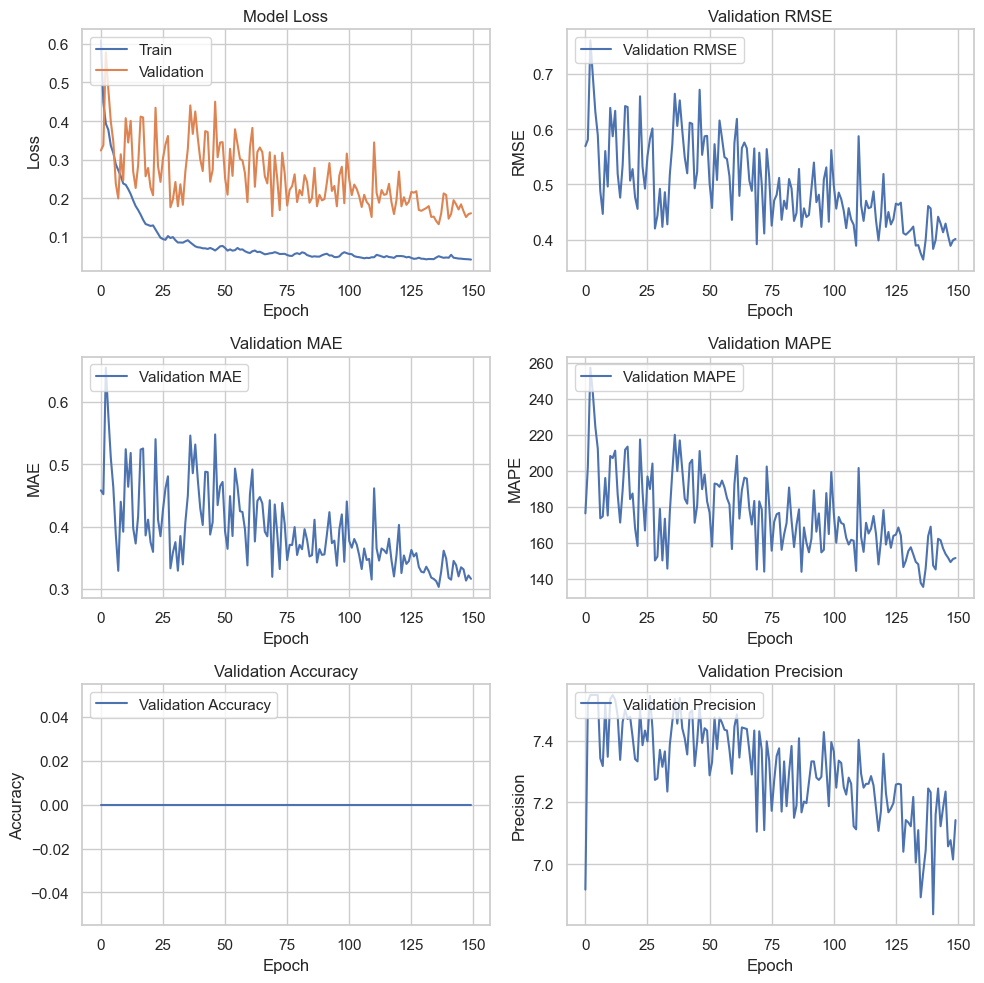

In [55]:
# Extract the metrics from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
val_rmse = history.history['val_rmse']
val_mae = history.history['val_mean_absolute_error']
val_mape = history.history['val_mape']
val_accuracy = history.history['val_accuracy']
val_precision = history.history['val_precision']

# Plot the performance metrics using seaborn
sns.set(style="whitegrid")

fig, axs = plt.subplots(3, 2, figsize=(10, 10))

# Plot training & validation loss values
sns.lineplot(x=range(len(train_loss)), y=train_loss, ax=axs[0, 0], label='Train')
sns.lineplot(x=range(len(val_loss)), y=val_loss, ax=axs[0, 0], label='Validation')
axs[0, 0].set_title('Model Loss')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].legend(loc='upper left')

# Plot RMSE values
sns.lineplot(x=range(len(val_rmse)), y=val_rmse, ax=axs[0, 1], label='Validation RMSE')
axs[0, 1].set_title('Validation RMSE')
axs[0, 1].set_ylabel('RMSE')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].legend(loc='upper left')

# Plot MAE values
sns.lineplot(x=range(len(val_mae)), y=val_mae, ax=axs[1, 0], label='Validation MAE')
axs[1, 0].set_title('Validation MAE')
axs[1, 0].set_ylabel('MAE')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].legend(loc='upper left')

# Plot MAPE values
sns.lineplot(x=range(len(val_mape)), y=val_mape, ax=axs[1, 1], label='Validation MAPE')
axs[1, 1].set_title('Validation MAPE')
axs[1, 1].set_ylabel('MAPE')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].legend(loc='upper left')

# Plot Accuracy values
sns.lineplot(x=range(len(val_accuracy)), y=val_accuracy, ax=axs[2, 0], label='Validation Accuracy')
axs[2, 0].set_title('Validation Accuracy')
axs[2, 0].set_ylabel('Accuracy')
axs[2, 0].set_xlabel('Epoch')
axs[2, 0].legend(loc='upper left')

# Plot Precision values
sns.lineplot(x=range(len(val_precision)), y=val_precision, ax=axs[2, 1], label='Validation Precision')
axs[2, 1].set_title('Validation Precision')
axs[2, 1].set_ylabel('Precision')
axs[2, 1].set_xlabel('Epoch')
axs[2, 1].legend(loc='upper left')

plt.tight_layout()
plt.show()

In [56]:
# Print the metrics
print("Training Loss: ", train_loss[-1])
print("Validation Loss: ", val_loss[-1])
print("Validation RMSE: ", val_rmse[-1])
print("Validation MAE: ", val_mae[-1])
print("Validation MAPE: ", val_mape[-1])
print("Validation Precision: ", val_precision[-1])

Training Loss:  0.04127694293856621
Validation Loss:  0.16130828857421875
Validation RMSE:  0.40163204073905945
Validation MAE:  0.31622305512428284
Validation MAPE:  151.54388427734375
Validation Precision:  7.142499923706055


In [25]:
#Make predictions
y_pred = model.predict(X_test)

# Print predictions
print("Predictions: ", y_pred)

# Calculate and print final evaluation metrics on the test set
final_rmse = np.sqrt(mean_squared_error(y_test.flatten(), y_pred.flatten()))
final_mae = mean_absolute_error(y_test.flatten(), y_pred.flatten())
final_mape = np.mean(np.abs((y_test.flatten() - y_pred.flatten()) / y_test.flatten())) * 100
final_precision = precision_score((y_test.flatten() > 0.5).astype(int), (y_pred.flatten() > 0.5).astype(int))

print("Final RMSE: ", final_rmse)
print("Final MAE: ", final_mae)
print("Final MAPE: ", final_mape)
print("Final Precision: ", final_precision)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Predictions:  [[[-1.9144421  -1.9558318  -1.9766378  ... -1.2131585   1.9120007
   -1.844094  ]
  [-1.9038157  -1.944475   -1.9480915  ... -1.2294266   1.8877529
   -1.8383579 ]
  [-1.8816756  -1.9210058  -1.9178654  ... -1.226988    1.8563235
   -1.8135275 ]
  ...
  [-1.4133472  -1.3878486  -1.3341964  ... -0.7848428   1.2183901
   -1.371603  ]
  [-1.4058466  -1.3840649  -1.3284814  ... -0.7911306   1.2072068
   -1.3570065 ]
  [-1.3709222  -1.3500553  -1.2987761  ... -0.7743354   1.1947199
   -1.3221856 ]]

 [[-1.9144423  -1.955832   -1.9766381  ... -1.2131585   1.9120009
   -1.844094  ]
  [-1.903816   -1.9444752  -1.9480917  ... -1.2294267   1.8877531
   -1.8383579 ]
  [-1.8816758  -1.9210061  -1.9178655  ... -1.2269881   1.856324
   -1.8135276 ]
  ...
  [-1.4133472  -1.3878486  -1.3341966  ... -0.7848428   1.21839
   -1.371603  ]
  [-1.4058466  -1.3840649  -1.3284814  ... -0.7911306   1.2072068
   -1.3570065 ]
  [-1.3709222  -1.3500553  -1.2987

In [26]:
# Inverse transform the predictions and the test data
y_pred_inverse = scaler.inverse_transform(y_pred.reshape(-1, y_pred.shape[-1])).reshape(y_pred.shape)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, y_test.shape[-1])).reshape(y_test.shape)

columnsnames=['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6','Feature7', 'Feature8']

## Convert predictions and actual values to separate DataFrames using original column names
actual_df = pd.DataFrame(y_test_inverse.reshape(-1, y_test_inverse.shape[-1]), columns=columnsnames)
predicted_df = pd.DataFrame(y_pred_inverse.reshape(-1, y_pred_inverse.shape[-1]), columns=columnsnames)


In [17]:
actual_df

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8
0,0.1208,86623.6320,84400.4660,1162.3136,422.0,1083.0,0.7723,0.1413
1,0.1208,86623.6320,84400.4660,1162.3136,422.0,1083.0,0.7723,0.1413
2,0.1208,86635.5211,84412.6135,1162.3136,422.0,1083.0,0.7722,0.1413
3,0.1293,89857.0463,87010.3655,1197.5529,442.0,1113.0,0.7758,0.1526
4,0.1297,90049.8254,86932.1158,1178.7947,439.0,1094.0,0.7706,0.1535
...,...,...,...,...,...,...,...,...
395,0.1387,92597.5043,90066.2099,1181.6302,449.0,1093.0,0.7577,0.1645
396,0.1386,92571.9423,90039.6155,1181.6302,449.0,1093.0,0.7579,0.1644
397,0.1386,92571.9423,90039.6155,1181.6302,449.0,1093.0,0.7579,0.1644
398,0.1387,92597.5043,90066.2099,1181.6302,449.0,1093.0,0.7577,0.1645


In [27]:
predicted_df

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8
0,0.113364,84140.117188,81797.242188,1156.503784,416.382751,1079.868774,0.782569,0.131508
1,0.113583,84213.781250,81954.000000,1156.764771,417.332825,1079.301025,0.782258,0.131673
2,0.114038,84366.007812,82119.976562,1157.089722,418.176849,1079.386108,0.781856,0.132389
3,0.114554,84458.851562,82192.031250,1158.088867,419.636658,1079.259644,0.781844,0.132938
4,0.115112,84688.109375,82333.531250,1159.704102,420.797913,1080.680664,0.782225,0.133822
...,...,...,...,...,...,...,...,...
395,0.123093,87627.687500,85034.804688,1173.046753,427.907990,1092.026001,0.774427,0.144564
396,0.123221,87732.265625,85160.281250,1174.472534,427.832062,1093.327881,0.774104,0.144670
397,0.123557,87792.398438,85297.210938,1176.147949,428.811005,1094.728516,0.773782,0.144995
398,0.123729,87822.726562,85336.585938,1176.291992,429.543793,1094.556274,0.773622,0.145431


In [59]:
model.save(r'/Users/I578087/Desktop/WaterLevel-main/Models/Test/RNN_test.keras')